# Utilizing Python for Remote Sensing Applications
Rebekah Esmaili [bekah@umd.edu](mailto:bekah@umd.edu)

STC / NOAA / University of Maryland

Code, Data, and Installation Guide: [https://ter.ps/agupy](https://ter.ps/agupy)


![](img/abi.jpg)


## Objective: working with satellite datasets

* You won't learn how to code in Python
* You will learn to:
	* Read/write netCDF datasets
	* Plotting and visualizing the data
	* Perform re-gridding, merging, averaging, filtering
    
---

# Recap on Packages
Packages give us additional functionality, saving us the trouble of writing procedures ourselves. 

Primary libraries from the last session...
* [NumPy](http://www.numpy.org/) Fast mathemtatical operations on large datasets.
* [Pandas](https://pandas.pydata.org) Encapsulation of data, easy read/write of ascii data. Builds extra functionality on top of NumPy.
* [Matplotlib](https://matplotlib.org) Primarily python plotting/visualization package. You can generate plots, histograms, scatterplots, etc., with just a few lines of code.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Options to print figures into notebook/increase size
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size': 16})

In [11]:
# Bring back our list of aeronet stations...
fname = 'data/aeronet_locations_v3.txt'
stationList = pd.read_csv(fname, skiprows=1)
stationList.columns = ['site', 'lon', 'lat', 'elev']

## [Cartopy](https://scitools.org.uk/cartopy/)
* Cartopy is not included in Anaconda, need to install yourself.

Open the terminal (Mac/Linix) or Anaconda Prompt (Windows) and type:
```python
conda install -c conda-forge cartopy
```
* Rather than import all of Cartopy, we just want the projection classes to pair with matplot lib.
* More [map projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html).

In [2]:
from cartopy import crs as ccrs

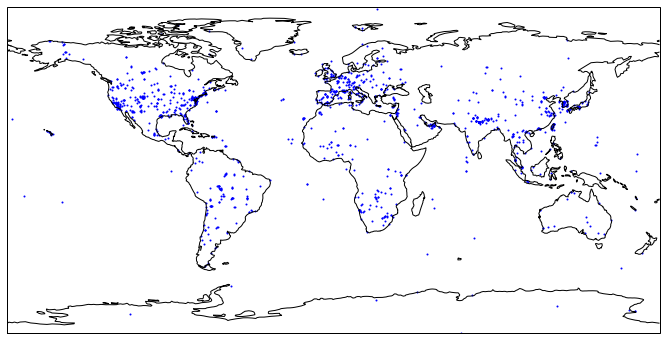

In [8]:
# Center on the Atlantic
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(stationList['lon'], stationList['lat'], color='blue', s=1)
plt.show()

<div class="alert alert-block alert-info">

**Exercise 1**

* Import aeronet_locations_v3.txt with read_csv
* Define the map axes using with option projection=ccrs.PlateCarree()
* Add coastlines
* Make a scatter plot of the station locations
* Don't forget to show the plot!

* Challenge: Shift the plot to center on -180 using ccrs.PlateCarree(central_longitude=-180)
</div>

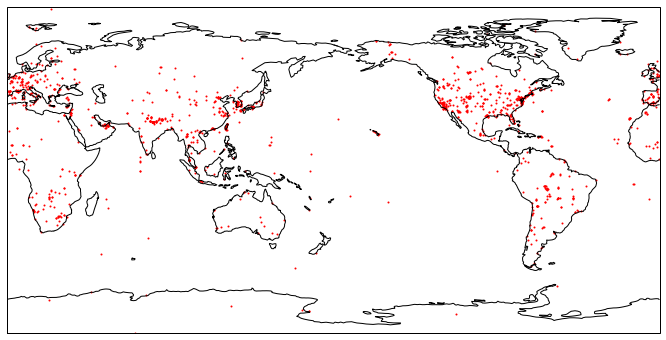

In [10]:
# Solution: Center on the Pacific (note the shift in the station longitude as well!)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()
plt.scatter(stationList['lon']-180, stationList['lat'], color='red', s=1)
#Option: transform the coordinates..
#plt.scatter(stationList['lon']-180, stationList['lat'], color='red', s=1, \
#            transform=ccrs.PlateCarree(central_longitude=-180))
plt.show()

# Examining the 2018 California Wildfires from Space

* 6,870 fires had burned over a 6,000 km${^2}$ area. 
* The smoke from the wildfires also had an impact on air quality both in proximity of the fires as well as across the country.
* We'll look at satellite observations from JPSS and GOES-16 to show the impact of the California wildfires on AOD.

### LEO Example: Suomi-NPP
LEO Satellites orbit the earth many times a day, data are oganized in 1 minute swaths per file.


In [4]:
from netCDF4 import Dataset

In [5]:
# Import your data...
fname='data/JRR-AOD_v1r1_npp_s201808091957192_e201808091958434_c201808092051240.nc'
file_id_NPP = Dataset(fname)

# Print a list of variables
list(file_id_NPP.variables.keys())

['Latitude',
 'Longitude',
 'StartRow',
 'StartColumn',
 'AOD550',
 'AOD_channel',
 'AngsExp1',
 'AngsExp2',
 'QCPath',
 'AerMdl',
 'FineMdlIdx',
 'CoarseMdlIdx',
 'FineModWgt',
 'SfcRefl',
 'SpaStddev',
 'Residual',
 'AOD550LndMdl',
 'ResLndMdl',
 'MeanAOD',
 'HighQualityPct',
 'RetrievalPct',
 'QCRet',
 'QCExtn',
 'QCTest',
 'QCInput',
 'QCAll']

In [6]:
AOD_NPP = file_id_NPP.variables['AOD550'][:,:]
lat_NPP = file_id_NPP.variables['Latitude'][:,:]
lon_NPP = file_id_NPP.variables['Longitude'][:,:]

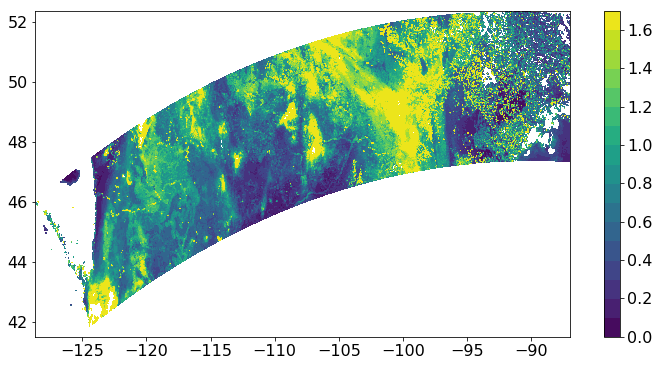

In [99]:
levs = np.arange(0, 1.8, 0.1)

plt.contourf(lon_NPP, lat_NPP, AOD_NPP, levs)
plt.colorbar()
plt.show()

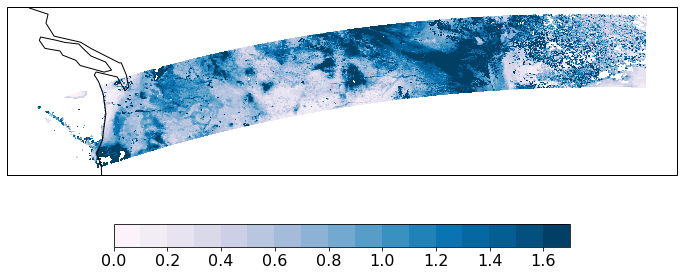

In [111]:
levs = np.arange(0, 1.8, 0.1)
img_proj = ccrs.PlateCarree()

# Using cartopy, create the map projection and plot the data
ax = plt.axes(projection=img_proj)
ax.coastlines()

# Can change color scheme using the get_cmap command
plt.contourf(lon_NPP, lat_NPP, AOD_NPP, levs, transform=img_proj, \
             cmap=plt.get_cmap("PuBu"))
plt.colorbar(orientation="horizontal", fraction=0.07)

# To zoom in on data:
# plt.xlim(-125, -120)
# plt.ylim(42, 44)
plt.show()

<div class="alert alert-block alert-info">

**Exercise 2** 

??? = Fill in the blanks!

**Import from netCDF files**

* Import JRR-AOD_v1r1_npp_s201808091957192_e201808091958434_c201808092051240.nc using the Dataset command.
* Inpect the available variables.
* Save the latitude, longitude, and AOD to arrays.

**Create a cartopy plot**

* Define the axes, including the projection. 
    * Challenge: Make an ortographic plot using: ccrs.Orthographic(central_longitude=-75.0, central_latitude=0.0)
* Create a plot using plt.contourf(???, ???, ???, transform=???)
    * Challenge: Change the data scale from the default to 0.0-1.8
* Remember to plt.show() at the end to display!

</div>

## Common tasks
1. Regridding
2. Masking datasets
3. Filtering with Quality Flags

### Regridding

Regridding is the process of interpolating from one grid resolution to a different grid resolution and [UCAR's website has a good discussion](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview). 

There are a few options:

* Interpolate using griddata from SciPy package (2D interpolate too slow/limited number of points)
* Regridding in iris package (autodetection of GRIB and NC fileformats... if they follow the conventions!)
* ESMF which is a wrapper for xarray (Unix only and kind of new. Keep your eyes on this one)
* __Pyresample__: the syntax can be fairly complex, but very fast

Pyresample also is not included in Anaconda, so install using:

```
conda install -c conda-forge pyresample

```

Steps:
1. Define the new grid (either in Python or import an irregular array)
2. Define the swath/satellite grid
3. Resample to get the new values for the updated grid

In [9]:
from pyresample import geometry
from pyresample.kd_tree import resample_nearest

In [10]:
# Create a new grid at 0.1 degree resolution
x = np.arange(lon_NPP.min(), lon_NPP.max(), 0.1)
y = np.arange(lat_NPP.min(), lat_NPP.max(), 0.1)
newLon, newLat = np.meshgrid(x,y)

# define the new grid using 
newLonLat = geometry.GridDefinition(lons=newLon, lats=newLat)

In [11]:
# Input list of swath points
oldLonLat = geometry.SwathDefinition(lons=lon_NPP, lats=lat_NPP)

# Resample the data
newAOD = resample_nearest(oldLonLat, AOD_NPP, newLonLat, radius_of_influence=5000, fill_value=None)

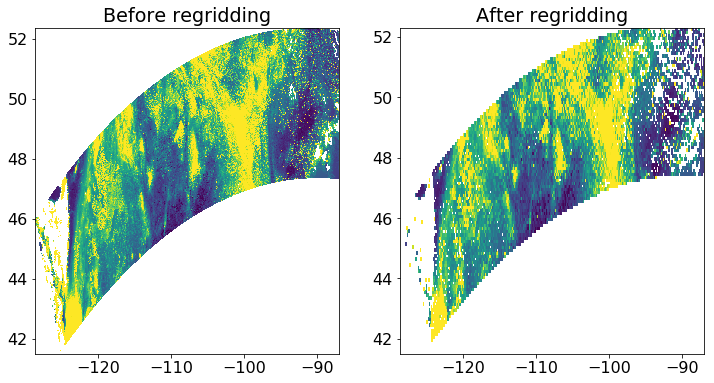

In [12]:
# To compare: Putting two plots together using plt.subplot
plt.subplot(1,2,1)
plt.title("Before regridding")
plt.pcolormesh(lon_NPP, lat_NPP, AOD_NPP, vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.pcolormesh(newLon, newLat, newAOD, vmin=0, vmax=1)
plt.title("After regridding")
plt.show()

### Masking Datasets

May want to add a land/ocean mask to our datasets

In [7]:
import cartopy.feature as feature

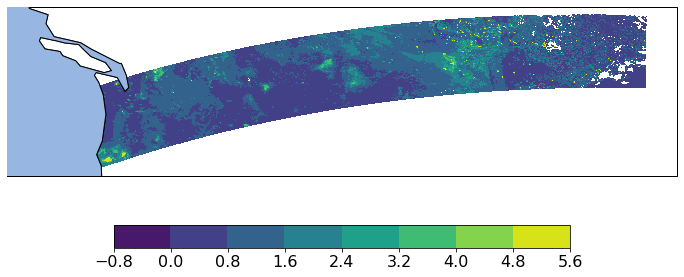

In [8]:
img_proj = ccrs.PlateCarree()

ax = plt.axes(projection=img_proj)
ax.coastlines()
plot = ax.contourf(lon_NPP, lat_NPP, AOD_NPP, transform=img_proj)

# Mask out the ocean: zorder places it on top of the existing data
ax.add_feature(feature.OCEAN, zorder=100, edgecolor='black')

cb = plt.colorbar(plot, orientation="horizontal", fraction=0.07)
plt.show()

### GEO Example: GOES-17
* Larger imagery (42% of earth), can take a while to load.
* Using CONUS datasets, but Full Disk Imagery is also available

### Un-scaling the data
* Data are often scaled integers to save disk space
* If the netCDF file is formatted properly, Python will unscale the data for you!

---
__Your legal disclaimer...__
"These GOES-17 data are preliminary, non-operational data and are undergoing testing. Users bear all responsibility for inspecting the data prior to use and for the manner in which the data are utilized."

---

In [30]:
fname  ='data/OR_ABI-L2-AODC-M3_G17_s20182211612186_e20182211614557_c20182211615551.nc'
file_id_G17 = Dataset(fname)
var = file_id_G17.variables['AOD'][:,:]
AOD_G17 = np.array(var)

In [65]:
# Where in the world is... latitude and longitude??
list(file_id_G17.variables.keys())

['AOD',
 'DQF',
 't',
 'y',
 'x',
 'time_bounds',
 'goes_imager_projection',
 'y_image',
 'y_image_bounds',
 'x_image',
 'x_image_bounds',
 'nominal_satellite_subpoint_lat',
 'nominal_satellite_subpoint_lon',
 'nominal_satellite_height',
 'geospatial_lat_lon_extent',
 'sunglint_angle',
 'sunglint_angle_bounds',
 'retrieval_local_zenith_angle',
 'quantitative_local_zenith_angle',
 'retrieval_local_zenith_angle_bounds',
 'quantitative_local_zenith_angle_bounds',
 'retrieval_solar_zenith_angle',
 'quantitative_solar_zenith_angle',
 'retrieval_solar_zenith_angle_bounds',
 'quantitative_solar_zenith_angle_bounds',
 'aod_product_wavelength',
 'land_sensor_band_wavelengths',
 'sea_sensor_band_wavelengths',
 'land_sensor_band_ids',
 'sea_sensor_band_ids',
 'latitude_bands',
 'latitude_band_bounds',
 'snow_free_land_and_ice_free_sea',
 'goes_lat_lon_projection',
 'aod550_retrievals_attempted_land',
 'aod550_retrievals_attempted_sea',
 'aod550_good_LZA_retrievals_attempted',
 'aod550_outlier_pix

### Georeferencing the data

* GOES makes fixed observations, so the Full Disk and CONUS files do not contain the lat/lon coordinates to save disc space (Mesoscale does contain lat/lon since the position changes).
* For the details on unscaling the geoference data (e.g. x, y &rarr; lon, lat), see the GOES-16 ATBD.
* For now, I provide the look-up tables so don't worry :-)

In [13]:
# Import lat/lon from look-up table (code is on GitHub if you want to make your own)
file_id_geo = Dataset('data/latlon_L2_G17_CONUS_89W.nc')
lat_G17 = file_id_geo.variables['latitude'][:,:]
lon_G17 = file_id_geo.variables['longitude'][:,:]

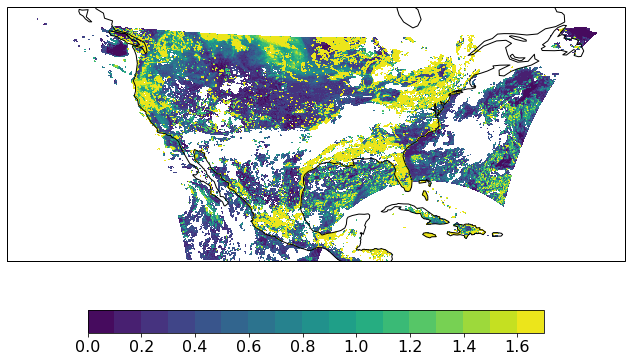

In [113]:
img_proj = ccrs.PlateCarree()
levs = np.arange(0, 1.8, 0.1)

# Then you can plot just like before (this is a little slow):
ax = plt.axes(projection=img_proj)
plt.contourf(lon_G17, lat_G17, AOD_G17, levs, transform=img_proj)
ax.coastlines()
plt.colorbar(orientation="horizontal", fraction=0.07)
plt.show()

### Filtering

* Remote sensing datasets commonly have "quality flags" to inform the user of uncertainly in the results.
* If your model or analysis is highly sensitive to the inputs, you should only use the __best quality__ data
* Quality flags are usually specified on a integer scale:
    * 0: Best
    * 1: Medium
    * 2: Low
    * 3: No retrieval

In [69]:
# Import quality flag
dqf = file_id_G17.variables['DQF'][:,:]

# Keep all but the "best" quality using masked arrays
maskHQ = (dqf != 0)
AOD_G17_HQ = np.ma.masked_where(maskHQ, AOD_G17)

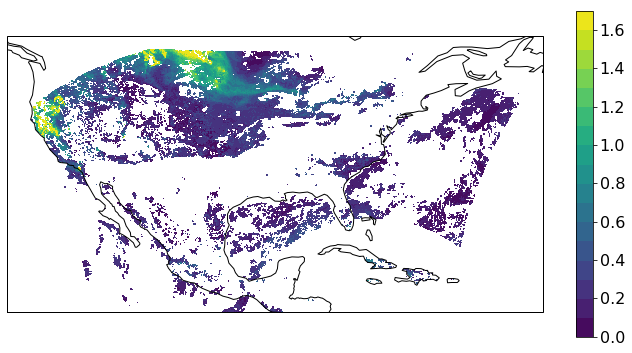

In [70]:
img_proj = ccrs.PlateCarree()
levs = np.arange(0, 1.8, 0.1)

# Re-plot only the "high quality" data
ax = plt.axes(projection=img_proj)
plt.contourf(lon_G17, lat_G17, AOD_G17_HQ, levs, transform=img_proj)
ax.coastlines()
plt.colorbar()
plt.show()

<div class="alert alert-block alert-info">

**Exercise 3**

* Filter your plot in Exercise 2 (using NPP data) by data quality using the variable 'QCAll'
* Import QCAll into a variable
* Create a mask for medium/low quality data or pixels with no retrieval
* Make a new map with the filtered data

</div>

In [114]:
dqfNPP = file_id_NPP.variables['QCAll'][:,:]

maskHQnpp = (dqfNPP != 0)
AOD_NPP_HQ = np.ma.masked_where(maskHQnpp, AOD_NPP)

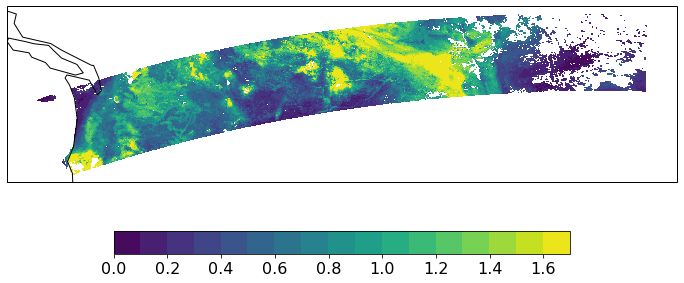

In [115]:
img_proj = ccrs.PlateCarree()
levs = np.arange(0, 1.8, 0.1)

ax = plt.axes(projection=img_proj)
plt.contourf(lon_NPP, lat_NPP, AOD_NPP_HQ, levs, transform=img_proj)
ax.coastlines()
plt.colorbar(orientation="horizontal", fraction=0.07)
plt.show()

## Saving images

* Create the plot, then use plt.savefig

In [ ]:
plt.pcolormesh(lon_NPP, lat_NPP, AOD_NPP, vmin=0, vmax=1)

# Add DPI option to change resolution of the plot (maintains the same aspect ratio)
plt.savefig('Wildfires_AOD_2018221_1612', dpi=500)

# TIP: If you want to suppress the output (runs faster!), use the following:
plt.close(fig)

### Saving as netCDF
* Steps are similar to how you open the file
* Try to follow [climate and forecast conventions](https://www.unidata.ucar.edu/software/netcdf/conventions.html)

In [84]:
# Open the dataset in "write mode"
rootgrp = Dataset('viirs-AOD1', "w", format="NETCDF4")

varShape = np.array(lon_NPP).shape

# Define the coordinates
latnc = rootgrp.createDimension("lat", varShape[0])
lonnc = rootgrp.createDimension("lon", varShape[1])

In [85]:
# Create the latitude and longitude variables
latitudes = rootgrp.createVariable("latitude","f4",("lat","lon"), \
    zlib=True, least_significant_digit=2)
longitudes = rootgrp.createVariable("longitude","f4",("lat","lon"), \
    zlib=True, least_significant_digit=2)

# Create the groupname for the variable
variable = rootgrp.createVariable('AOD550', 'f4',("lat","lon"), \
    zlib = True, fill_value = -999.0)

In [86]:
# Fill in some Metadata
rootgrp.description = "High quality VIIRS AOD"
latitudes.units = "degrees_north"
longitudes.units = "degrees_east"
variable.long_name = "Aerosol Optical Depth"

In [87]:
# Finally, fill in the variables
variable[:,:] = AOD_NPP_HQ
latitudes[:,:] = lat_NPP
longitudes[:,:] = lon_NPP

In [88]:
# If you do not close, the file will not be usable!
rootgrp.close()

## Scripting

* Notebooks are nice for sharing results with others, but scripts are useful for automating tasks.
* You can export a script from Jupyter Notebook directly: File &rarr; Download As &rarr; Python (.py)
* To make a script, write code into a [filename].py file with the following shebang:
```python
#!/usr/bin/env python
```

Then to call the script, open the terminal, check the file permissions, and simply type:
```python
python rgb.py
```
Windows users: you'll need to run the scripts through the Anaconda Prompt and use the full path to the script using double backslashes (\\\\). You may need to associate \*.py files with python (C:\Users\[your username]\Anaconda3\python) 


## Resources
* [xarray](http://xarray.pydata.org) provides multidimensional operations to pandas data structures. **This package is worth your time to learn/use.**
* [PyTroll](http://pytroll.github.io) framework for the processing of earth observation satellite data
* [Unidata AWIPS Python tutorial](http://unidata.github.io/awips2/python/satellite-imagery/)
* [Workshop on developing Python frameworks for earth system sciences](https://www.ecmwf.int/en/learning/workshops/2018-workshop-developing-python-frameworks-earth-system-sciences)
* [Python Satellite Data Analysis Toolkit (pysat)](https://github.com/rstoneback) Toolkit for space science data analysis.